# Model Inspection

In [1]:
using Flux
using Plots
using BSON
using StatsBase

In [2]:
using MultivariateStats
using TSne

In [3]:
using Revise
using TokenizersLite
using TransformersLite

## Load

In [4]:
directory = "../outputs/20220517_1516"

"../outputs/20220517_1516"

In [5]:
add_position_encoding(x) = x .+ PositionEncoding(32)(x)

add_position_encoding (generic function with 1 method)

In [6]:
BSON.@load joinpath(directory, "model.bson") model
model

TransformerClassifier(
     Embed(32, 7455),                   # 238_560 parameters
     PositionEncoding(32),
     TransformerEncoderBlock(
          MultiheadAttention(num_heads=4, head_size=8, 32=>32)(
               denseQ = Dense(32 => 32),  # 1_056 parameters
               denseK = Dense(32 => 32),  # 1_056 parameters
               denseV = Dense(32 => 32),  # 1_056 parameters
               denseO = Dense(32 => 32),  # 1_056 parameters
          )
          LayerNorm(32),                # 64 parameters
          Dense(32 => 128, relu),       # 4_224 parameters
          Dense(128 => 32),             # 4_128 parameters
          LayerNorm(32),                # 64 parameters
     )     MeanLayer(),
     Dense(50 => 1),                    # 51 parameters
)                  # Total: 19 arrays, 251_315 parameters, 1.082 MiB.

In [7]:
vocab_directory = "../vocab\\bpe"
path_vocab = joinpath(vocab_directory, "amazon_reviews_train_en_vocab.txt")
vocab = load_vocab(path_vocab)
indexer = IndexTokenizer(vocab, "[UNK]")

IndexTokenizer{String}(length(vocabulary)=7455, unksym=[UNK])

## Inspect

### Embeddings

In [8]:
embedding_means = mean(model.embed.embedding, dims=1)

1×7455 Matrix{Float32}:
 0.0504029  0.10553  0.146791  -0.149458  …  -0.164816  0.206771  0.199857

In [9]:
magnitudes = sqrt.(sum(model.embed.embedding.^2, dims=1))

1×7455 Matrix{Float32}:
 5.93032  5.32777  5.86731  5.67754  …  5.47022  4.87155  5.22832  5.04873

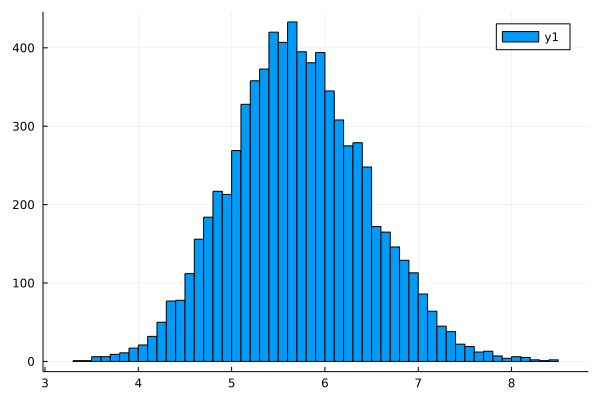

In [10]:
histogram(vec(magnitudes))

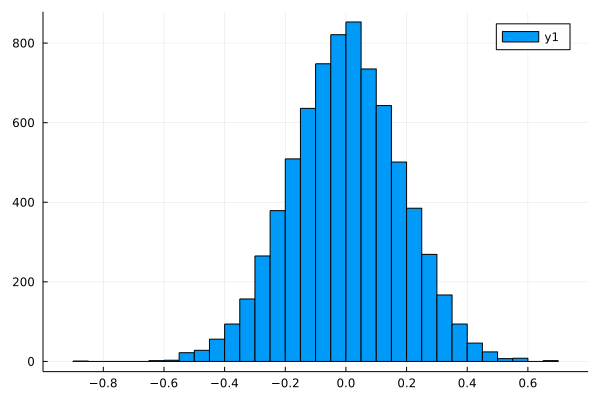

In [11]:
histogram(vec(embedding_means))

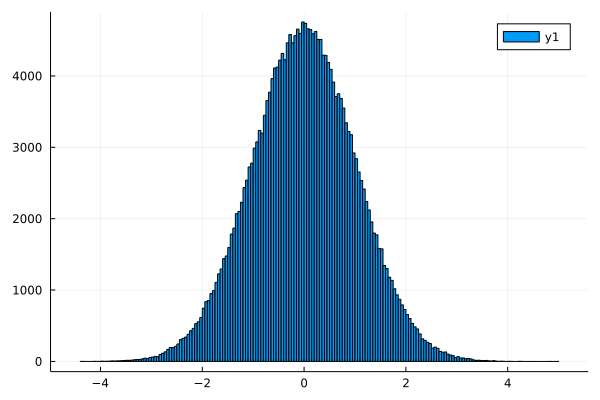

In [12]:
histogram(reshape(model.embed.embedding, :, 1))

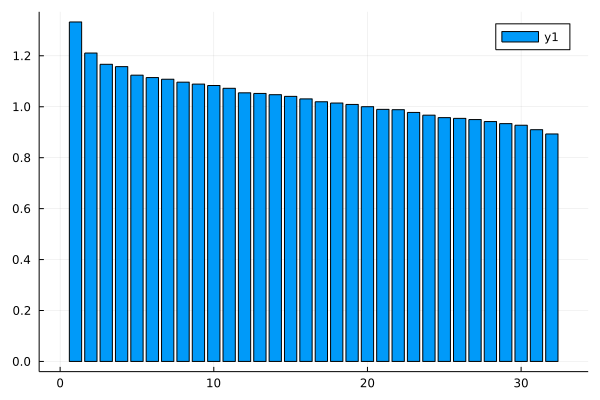

In [13]:
pca = fit(PCA, model.embed.embedding; maxoutdim=32)
bar(principalvars(pca))

In [14]:
pca = fit(PCA, model.embed.embedding; maxoutdim=2)

PCA(indim = 32, outdim = 2, principalratio = 0.076580055)

Pattern matrix (unstandardized loadings):
─────────────────────────────
             PC1          PC2
─────────────────────────────
1   -0.137065      0.0576461
2    0.317569      0.0604506
3    0.282479      0.104614
4    0.18474      -0.103178
5   -0.348935     -0.162434
6    0.0301605     0.301554
7    0.270022     -0.00983561
8    0.293342     -0.203741
9    0.0245595     0.249425
10   0.261015     -0.0358109
11   0.0450635    -0.212537
12  -0.159096     -0.272951
13   0.00901027    0.547844
14   0.0973949    -0.0261845
15  -0.367892     -0.0575787
16   0.0219393     0.258423
17  -0.105385     -0.270571
18   0.0719579     0.169624
19  -0.253802      0.00403483
20  -0.256675      0.0422698
21  -0.254488      0.193953
22  -0.000279306   0.299519
23  -0.0619757    -0.252396
24   0.266751     -0.0282343
25   0.230546      0.10456
26  -0.235884      0.0350384
27  -0.0933734    -0.0495361
28   0.20077      -0.35816
29   0.133369 

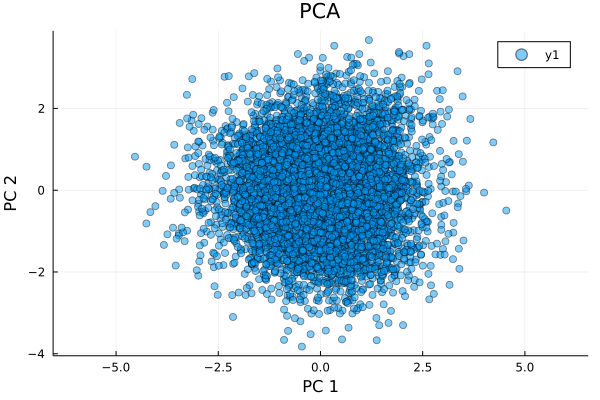

In [15]:
Y_pca = predict(pca, model.embed.embedding)
scatter(Y_pca[1, :], Y_pca[2, :], alpha=0.5, aspectratio=:equal, title="PCA", xlabel="PC 1", ylabel="PC 2")

In [16]:
function discretize_1d(X, res; dim=1)
    if size(X, 2) == 1
        return [[1]]
    end
    idxs_sorted = sortperm(X[dim, :])
    X = X[:, idxs_sorted]
    x_extrema = (X[dim, 1], X[dim, end])
    
    idxs = Vector{Vector{Int}}()
    idx = 1
    x_next = x_extrema[1] + res
    while x_next < x_extrema[2] + res
        idx_start = idx
        while (idx <= size(X, 2)) && (X[dim, idx] < x_next)
            idx += 1
        end  
        if (idx == idx_start)
        else
            push!(idxs, idxs_sorted[idx_start:(idx-1)])
        end
        x_next += res
    end
    idxs
end

function downsample_2d(X, res=0.5)
    idxs = Int[]
    total = 0
    for col in discretize_1d(X, res; dim=1)
        X_col = X[:, col]
        for row in discretize_1d(X_col, res; dim=2)
            idx = sample(row)
            push!(idxs, col[idx])
        end
    end
    idxs
end

downsample_2d (generic function with 2 methods)

227


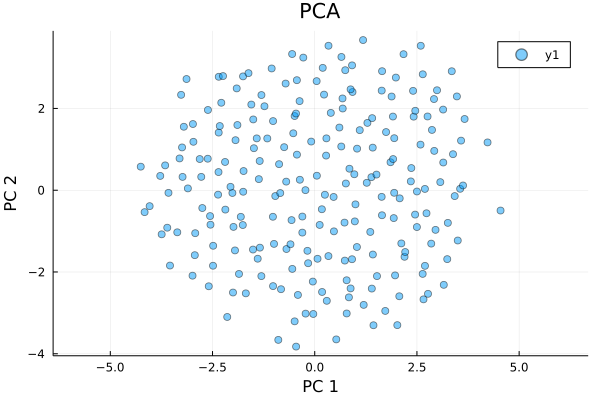

In [17]:
idxs = downsample_2d(Y_pca, 0.45)
println(length(idxs))
scatter(Y_pca[1, idxs], Y_pca[2, idxs], alpha=0.5, aspectratio=:equal, title="PCA", xlabel="PC 1", ylabel="PC 2")

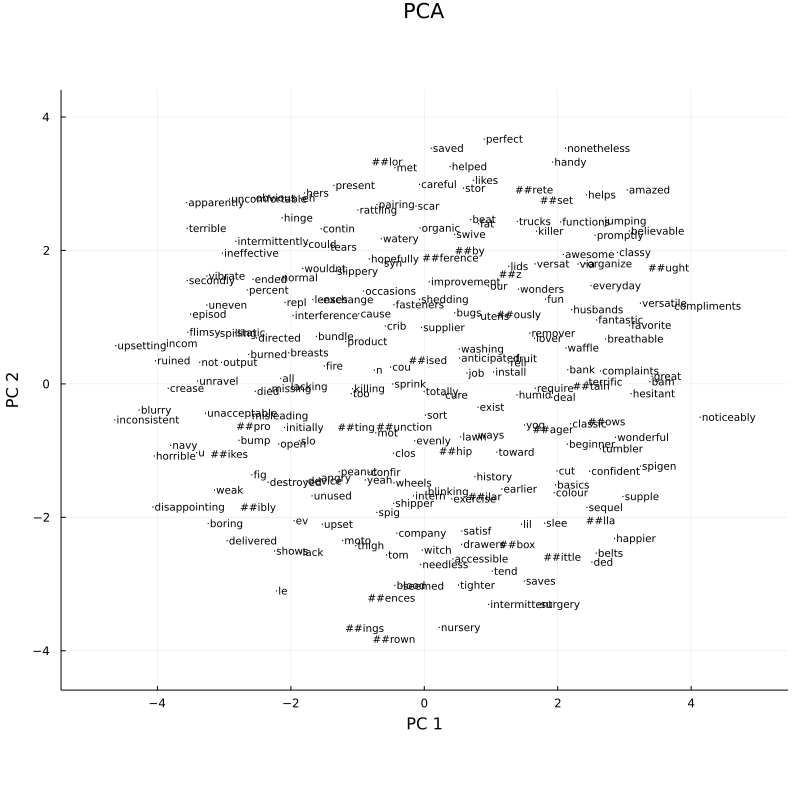

In [18]:
annotations = [
    (Y_pca[1, idx], Y_pca[2, idx], (indexer.vocabulary[idx], 7, :centre)) for idx in idxs
]
plot(size=(800, 800))
annotate!(annotations)

scale = 1.2
x_min = scale * minimum(Y_pca[1, :])
x_max = scale * maximum(Y_pca[1, :])
y_min = scale * minimum(Y_pca[2, :])
y_max = scale * maximum(Y_pca[2, :])

plot!(xlims=(x_min, x_max), ylims=(y_min, y_max), 
    aspectratio=:equal, title="PCA", xlabel="PC 1", ylabel="PC 2"
)

In [19]:
idxs = downsample_2d(Y_pca, 0.35)
length(idxs)

350

In [20]:
X = model.embed.embedding[:, idxs[1:length(idxs)]]
Y_tsne = tsne(transpose(X), 2, 50, 1000, 20.0);

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter C:\Users\sinai\.julia\packages\ProgressMeter\sN2xr\src\ProgressMeter.jl:618
Computing t-SNE 100%|████████████████████████████████████| Time: 0:00:03
  KL_divergence:  1.8179


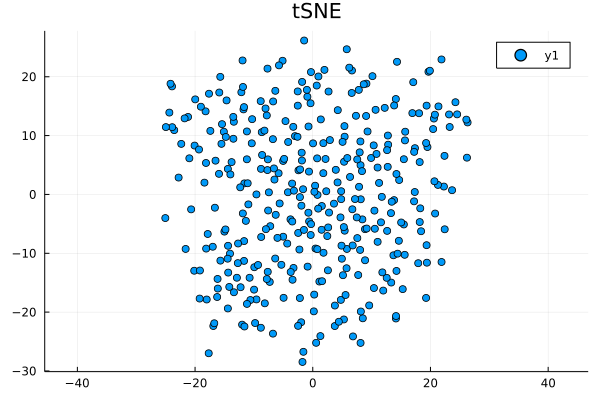

In [21]:
scatter(Y_tsne[:, 1], Y_tsne[:, 2], aspectratio=:equal, title="tSNE")

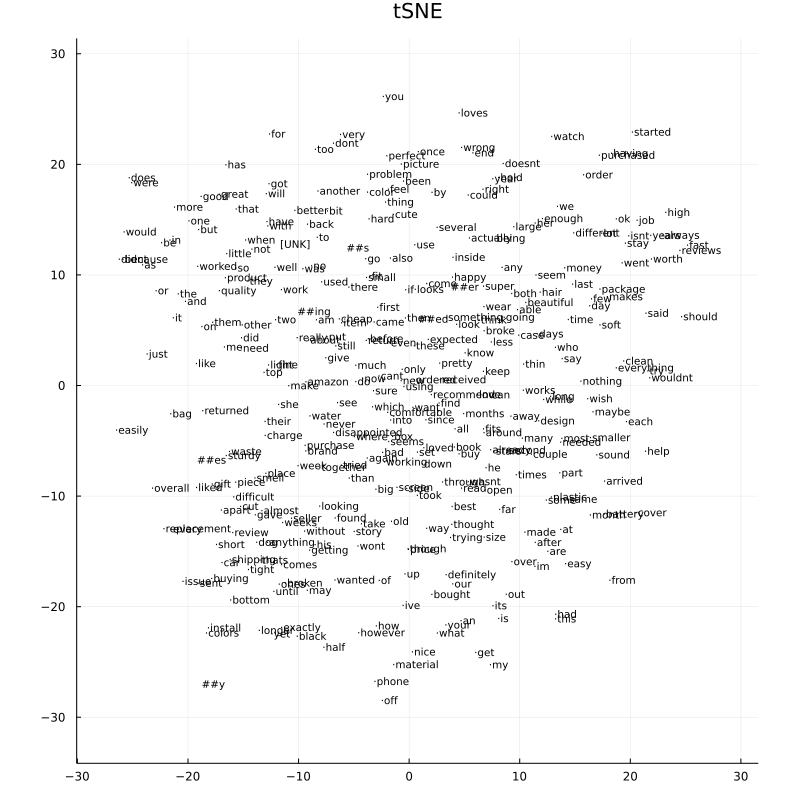

In [22]:
annotations = [
    (Y_tsne[idx, 1], Y_tsne[idx, 2], Plots.text(indexer.vocabulary[idx], 7, :centre)) for idx in 1:length(idxs)
]
plot(size=(800, 800))
annotate!(annotations)

scale = 1.2
x_min = scale * minimum(Y_tsne[:, 1])
x_max = scale * maximum(Y_tsne[:, 1])
y_min = scale * minimum(Y_tsne[:, 2])
y_max = scale * maximum(Y_tsne[:, 2])

plot!(xlims=(x_min, x_max), ylims=(y_min, y_max), aspectratio=:equal, title="tSNE")

### multi-head attention

In [23]:
model.encoder_layers[1].multihead_attention

MultiheadAttention(num_heads=4, head_size=8, 32=>32)(
     denseQ = Dense(32 => 32),          # 1_056 parameters
     denseK = Dense(32 => 32),          # 1_056 parameters
     denseV = Dense(32 => 32),          # 1_056 parameters
     denseO = Dense(32 => 32),          # 1_056 parameters
)                  # Total: 8 arrays, 4_224 parameters, 16.945 KiB.

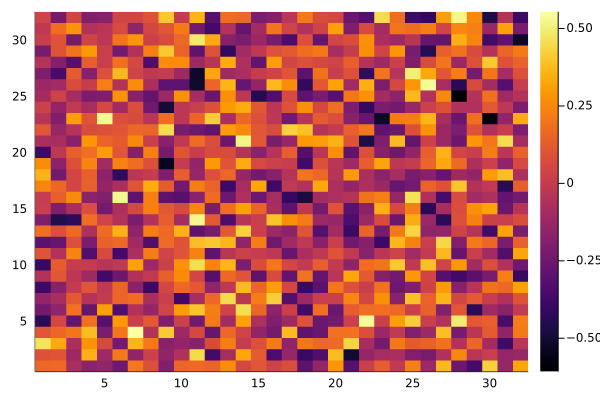

In [24]:
heatmap(model.encoder_layers[1].multihead_attention.denseK.weight)

In [25]:
model.encoder_layers[1]

TransformerEncoderBlock(
     MultiheadAttention(num_heads=4, head_size=8, 32=>32)(
          denseQ = Dense(32 => 32),     # 1_056 parameters
          denseK = Dense(32 => 32),     # 1_056 parameters
          denseV = Dense(32 => 32),     # 1_056 parameters
          denseO = Dense(32 => 32),     # 1_056 parameters
     )
     LayerNorm(32),                     # 64 parameters
     Dense(32 => 128, relu),            # 4_224 parameters
     Dense(128 => 32),                  # 4_128 parameters
     LayerNorm(32),                     # 64 parameters
)                  # Total: 16 arrays, 12_704 parameters, 50.703 KiB.

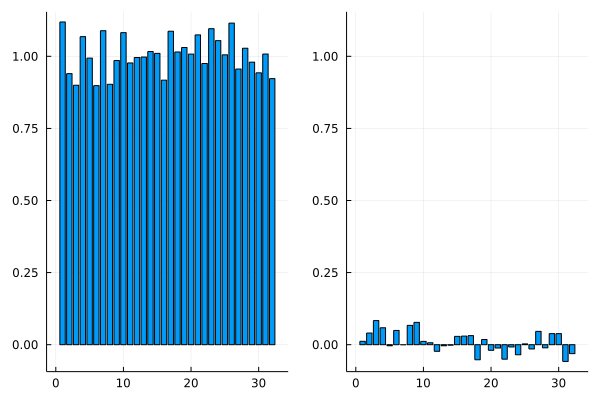

In [26]:
p1 = bar(model.encoder_layers[1].layer_norm_attention.diag.scale, label="")
p2 = bar(model.encoder_layers[1].layer_norm_attention.diag.bias, label="")

plot(p1, p2, link=:y)

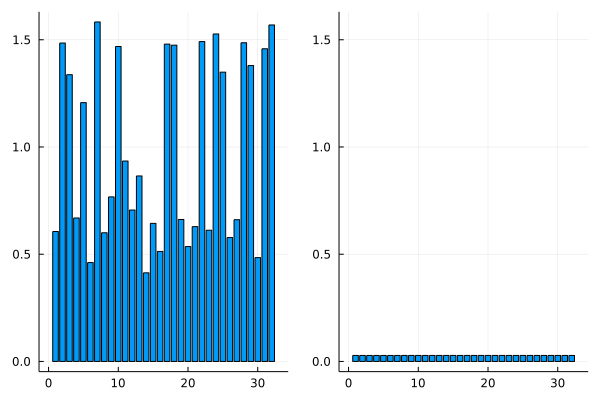

In [27]:
p1 = bar(model.encoder_layers[1].layer_norm_feedforward.diag.scale, label="")
p2 = bar(model.encoder_layers[1].layer_norm_feedforward.diag.bias, label="")

plot(p1, p2, link=:y)

### Output layer

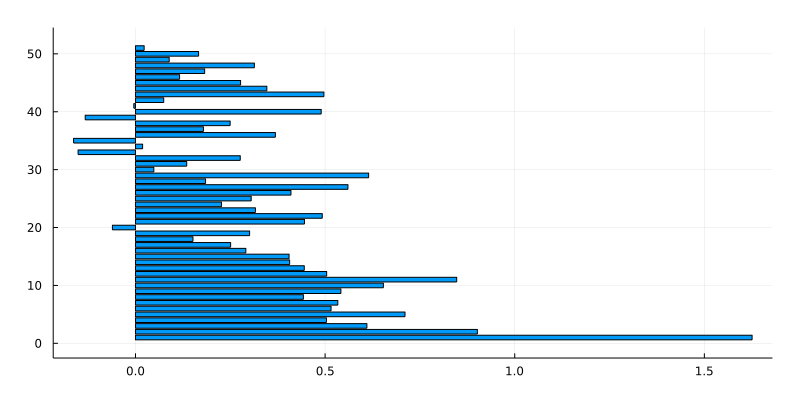

In [28]:
n_out = size(model.classifier.weight, 1)
canvases = []
for i in 1:n_out
    W = vcat(model.classifier.weight[i, :], model.classifier.bias[i])
    p = bar(1:length(W), vec(W), orientation=:horizontal, label="")
    push!(canvases, p)
end
    
p =plot(canvases..., layout=(1, 5), link=:x, size=(800, 400), margin=5Plots.mm)